In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'wheat', 'gold']

In [3]:
df = pd.read_csv('./data/co2.csv')
df.columns = df.columns.str.upper()

# Get cage to tracer meta data
metda_data = df.groupby(['CAGE', 'DAY','TRACER', 'TRACER_UMOL_MIN']).size().reset_index(name='COUNTS')  

# Curate data 
# Change Day entries from 2/3 to non-perturbative / perturbative
df['DAY'] = df['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')
df.head()

mapping = {'3hb': '3-hydroxybutyrate', 'glucose': 'glucose', 'lactate': 'lactate',}
df['TRACER'] = df['TRACER'].replace(mapping)



In [4]:
#data_filtered = df[(df['TIME'] >= 10) & (df['TIME'] <= 150) ]
#sns.lineplot(data=data_filtered, x='TIME', y='CO2_FLUX', hue='TRACER', style='DAY',palette=colors_met,)

In [5]:
#sns.lineplot(data=data_filtered, x='TIME', y='VCO2', hue='TRACER', style='DAY',palette=colors_met,)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, )

In [6]:
# Load serum labeling data 
df2 = pd.read_csv('./data/perturbative_experiments_labeling_combined_240804.csv')
df2.columns = df2.columns.str.upper()
df2 = df2.melt(id_vars=['COMPOUND', 'C_LABEL'])

# Fetch data from variable column
# Day1_Cage2_T0 -> Day = 1 , Cage = 2, Time = 0
df2['DAY'] = df2['variable'].apply(lambda x: int(x.split('_')[0][3:])) + 1
df2['CAGE'] = df2['variable'].apply(lambda x: int(x.split('_')[1][4:]))
df2['TIME'] = df2['variable'].apply(lambda x: int(x.split('_')[2][1:]))

# Integate metadata based on cage and day
df2 = pd.merge(df2, metda_data, on=['CAGE', 'DAY'])

df2['DAY'] = df2['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')

df2.head()

# Make tracer and compound names consistent
df2['COMPOUND'] = df2['COMPOUND'].apply(lambda x: x.lower())
mapping = {'3hb': '3-hydroxybutyrate_4', 'glucose': 'glucose_6', 'lactate': 'lactate_3',}
df2['TRACER'] = df2['TRACER'].replace(mapping)

df2['COMPOUND_LABEL'] = df2['COMPOUND']+ '_' + df2['C_LABEL'].astype(str)

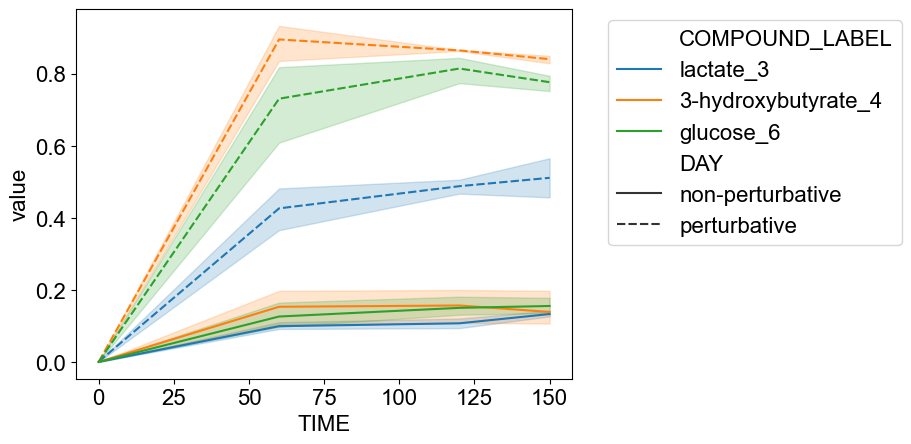

In [7]:
data_filtered = df2[(df2['TIME'] >= 0) & (df2['TIME'] <= 200) & (df2['COMPOUND_LABEL'] == df2['TRACER'])]

sns.lineplot(data=data_filtered, x='TIME', y='value', hue='COMPOUND_LABEL', style='DAY',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, )

In [8]:
TIME = [120, 130]

In [9]:
# Load serum metabolomics data
df3 = pd.read_csv('./data/perturbative_experiments_pool_size_combined_240804.csv')
df3.columns = df3.columns.str.upper()

# Substract blank values from data
blank = df3['Blank_before_plasma_2'.upper()]
df3 = df3.drop(columns=['Blank_before_plasma_2'.upper()])
df3.iloc[:,1:] = df3.iloc[:,1:].sub(blank, axis=0)

df3 = df3.melt(id_vars=['COMPOUND'])
# Fetch data from variable column
# Day1_Cage2_T0 -> Day = 1 , Cage = 2, Time = 0
df3['DAY'] = df3['variable'].apply(lambda x: int(x.split('_')[0][3:])) + 1
df3['CAGE'] = df3['variable'].apply(lambda x: int(x.split('_')[1][4:]))
df3['TIME'] = df3['variable'].apply(lambda x: int(x.split('_')[2][1:]))

# Integate metadata based on cage and day
df3 = pd.merge(df3, metda_data, on=['CAGE', 'DAY'])

print(df3.head())

df3['DAY'] = df3['DAY'].apply(lambda x: 'non-perturbative' if x == 2 else 'perturbative')



            COMPOUND        variable         value  DAY  CAGE  TIME TRACER  \
0  3-hydroxybutyrate   DAY1_CAGE3_T0  1.515275e+07    2     3     0    3hb   
1            lactate   DAY1_CAGE3_T0  1.055953e+08    2     3     0    3hb   
2            Glucose   DAY1_CAGE3_T0  3.163869e+07    2     3     0    3hb   
3  3-hydroxybutyrate  DAY1_CAGE3_T60  1.812762e+07    2     3    60    3hb   
4            lactate  DAY1_CAGE3_T60  5.729647e+07    2     3    60    3hb   

   TRACER_UMOL_MIN  COUNTS  
0           0.4016    1449  
1           0.4016    1449  
2           0.4016    1449  
3           0.4016    1449  
4           0.4016    1449  


In [10]:
# Normalize by mean repsective non-perturbative day 1 values 
# For each compound, calculate mean of non-perturbative day 1 values
df3_non_perturbative_day1 = df3[(df3['DAY'] == 'non-perturbative') & (TIME[0] <= df3['TIME']) & (df3['TIME'] <= TIME[1])]
df3_non_perturbative_day1 = df3_non_perturbative_day1.groupby('COMPOUND')['value'].mean().reset_index(name='MEAN_NON_PERTURBATIVE_DAY1')

# Merge mean values with original data
df3 = pd.merge(df3, df3_non_perturbative_day1, on='COMPOUND')

# Normalize values
df3['value_normalized'] = df3['value'] / df3['MEAN_NON_PERTURBATIVE_DAY1']

# Make tracer and compound names consistent
df3['COMPOUND'] = df3['COMPOUND'].apply(lambda x: x.lower())
mapping = {'3hb': '3-hydroxybutyrate', 'glucose': 'glucose', 'lactate': 'lactate',}
df3['TRACER'] = df3['TRACER'].replace(mapping)

In [11]:
# order of compounds
order = ['glucose', 'lactate', '3-hydroxybutyrate',]
hue_order = ['non-perturbative', 'perturbative']

# Pairs to test for statistical significance
pairs = [ (('glucose','non-perturbative') , ('glucose','perturbative')), 
            (('lactate','non-perturbative') , ('lactate','perturbative')),
            (('3-hydroxybutyrate','non-perturbative') , ('3-hydroxybutyrate','perturbative'))]
  

colors = ['darkgrey', 'white', ]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lactate_non-perturbative vs. lactate_perturbative: t-test paired samples, P_val:5.308e-04 t=-1.600e+01
glucose_non-perturbative vs. glucose_perturbative: t-test paired samples, P_val:9.577e-03 t=-5.931e+00
3-hydroxybutyrate_non-perturbative vs. 3-hydroxybutyrate_perturbative: t-test paired samples, P_val:6.296e-03 t=-1.254e+01


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_49879/1749892639.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()


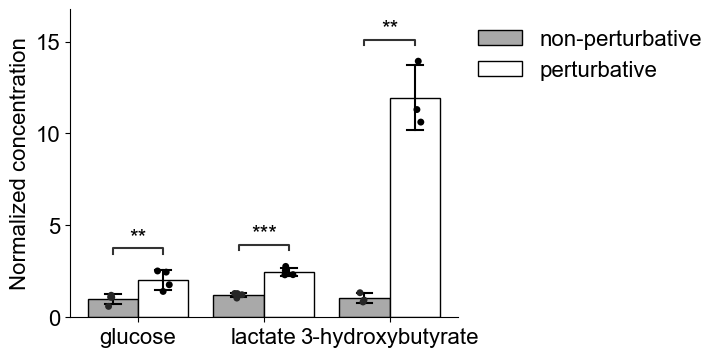

In [12]:
# Figure 1 Perturbative vs non-perturbative concentrations, rate of appearnace and reate of disappearance


# a) Concentrations
f, ax = plt.subplots(1, 1, figsize=(5, 4))
data_filtered = df3[(df3['TRACER'] == df3['COMPOUND']) & (df3['TIME'] >= TIME[0]) & (df3['TIME'] <= TIME[1])]
data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()

sns.barplot(data=data_filtered, x='COMPOUND', y='value_normalized', hue='DAY', palette=colors,
            errorbar='sd',capsize=0.25,  edgecolor='black', err_kws={'color': 'black','linewidth': 1.5},
            order=order, hue_order=hue_order)
            
sns.stripplot(data=data_filtered, x='COMPOUND', y='value_normalized', hue='DAY', dodge=True, size=5, 
              alpha=1.0, palette='dark:black', legend=False, order=order)
sns.despine()

plt.ylabel('Normalized concentration')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
       

annotator = Annotator(ax, pairs, data=data_filtered,
                      x='COMPOUND', y='value_normalized',
                      hue='DAY' , order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('./output/concentration.svg',bbox_inches='tight')

p-value annotation legend:

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_49879/609388544.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()



      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lactate_non-perturbative vs. lactate_perturbative: t-test paired samples, P_val:5.271e-02 t=3.114e+00
glucose_non-perturbative vs. glucose_perturbative: t-test paired samples, P_val:1.154e-01 t=2.198e+00
3-hydroxybutyrate_non-perturbative vs. 3-hydroxybutyrate_perturbative: t-test paired samples, P_val:4.770e-01 t=8.678e-01


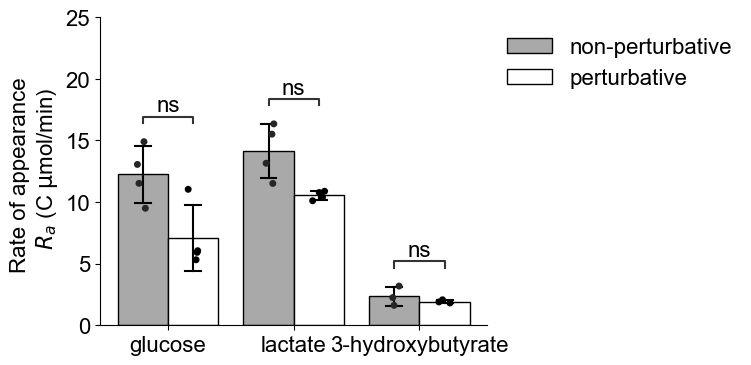

In [13]:
# b) Rate of appearance
f, ax = plt.subplots(1, 1, figsize=(5, 4))
data_filtered = df2[(df2['TRACER'] == df2['COMPOUND_LABEL']) & (df2['TIME'] >= TIME[0]) & (df2['TIME'] <= TIME[1])]
data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()


# Copute rate of appearance usin the enrichment 
data_filtered['RA'] = data_filtered['TRACER_UMOL_MIN'] * (1 - data_filtered['value'])/ data_filtered['value']

sns.barplot(data=data_filtered, x='COMPOUND', y='RA', hue='DAY', palette=colors,
            errorbar='sd',capsize=0.25,  edgecolor='black', err_kws={'color': 'black','linewidth': 1.5}, order=order
            , hue_order=hue_order)

sns.stripplot(data=data_filtered, x='COMPOUND', y='RA', hue='DAY', dodge=True, size=5,
                alpha=1.0, palette='dark:black', legend=False, order=order) 
sns.despine()

plt.ylabel('Rate of appearance \n $R_a$ (C $\mathrm{\mu}$mol/min)')   
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

plt.ylim(0, 25)

# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)


annotator = Annotator(ax, pairs, data=data_filtered,
                        x='COMPOUND', y='RA',
                        hue='DAY' , order=order, hue_order=hue_order)

annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('./output/rate_of_appearance.svg',bbox_inches='tight')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lactate_non-perturbative vs. lactate_perturbative: t-test paired samples, P_val:2.389e-02 t=-4.249e+00
glucose_non-perturbative vs. glucose_perturbative: t-test paired samples, P_val:5.469e-03 t=-7.224e+00
3-hydroxybutyrate_non-perturbative vs. 3-hydroxybutyrate_perturbative: t-test paired samples, P_val:4.545e-03 t=-1.478e+01


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_49879/3375247377.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()


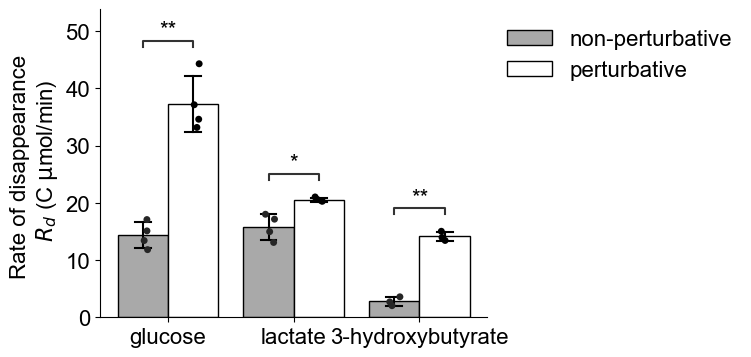

In [14]:
# c) Rate of disappearance

f, ax = plt.subplots(1, 1, figsize=(5, 4))
data_filtered = df2[(df2['TRACER'] == df2['COMPOUND_LABEL']) & (df2['TIME'] >= TIME[0]) & (df2['TIME'] <= TIME[1])]
data_filtered = data_filtered.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()

# Copute rate of appearance usin the enrichment
data_filtered['RA'] = (data_filtered['TRACER_UMOL_MIN'] * (1 - data_filtered['value'])/ data_filtered['value'] )
data_filtered['RD'] = data_filtered['TRACER_UMOL_MIN'] + data_filtered['RA'] 

sns.barplot(data=data_filtered, x='COMPOUND', y='RD', hue='DAY', palette=colors,
            errorbar='sd',capsize=0.25,  edgecolor='black', err_kws={'color': 'black','linewidth': 1.5}, order=order)   

sns.stripplot(data=data_filtered, x='COMPOUND', y='RD', hue='DAY', dodge=True, size=5,
                alpha=1.0, palette='dark:black', legend=False, order=order) 

sns.despine()

plt.ylabel('Rate of disappearance \n $R_d$ (C $\mathrm{\mu}$mol/min)')   
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

plt.ylim(0, 50)

# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

annotator = Annotator(ax, pairs, data=data_filtered,
                        x='COMPOUND', y='RD',
                        hue='DAY' , order=order, hue_order=hue_order)

annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('./output/rate_of_disappearance.svg',bbox_inches='tight')


In [15]:
data_filtered

,COMPOUND,TRACER,DAY,CAGE,C_LABEL,value,TIME,TRACER_UMOL_MIN,COUNTS,RA,RD
0,3-hydroxybutyrate,3-hydroxybutyrate_4,non-perturbative,3,4.0,0.199621,120.0,0.40160,1449.0,1.610217,2.011817
1,3-hydroxybutyrate,3-hydroxybutyrate_4,non-perturbative,6,4.0,0.161503,120.0,0.43200,1449.0,2.242877,2.674877
2,3-hydroxybutyrate,3-hydroxybutyrate_4,non-perturbative,11,4.0,0.108681,120.0,0.38720,1449.0,3.175529,3.562729
3,3-hydroxybutyrate,3-hydroxybutyrate_4,perturbative,3,4.0,0.864688,120.0,12.04800,599.0,1.885347,13.933347
4,3-hydroxybutyrate,3-hydroxybutyrate_4,perturbative,6,4.0,0.862748,120.0,12.96000,599.0,2.061773,15.021773
5,3-hydroxybutyrate,3-hydroxybutyrate_4,perturbative,11,4.0,0.865692,120.0,11.61600,599.0,1.802172,13.418172
6,glucose,glucose_6,non-perturbative,1,6.0,0.135270,120.0,2.04120,1449.0,13.048581,15.089781
7,glucose,glucose_6,non-perturbative,4,6.0,0.127457,120.0,2.17560,1449.0,14.893671,17.069271
8,glucose,glucose_6,non-perturbative,9,6.0,0.196297,120.0,2.31840,1449.0,9.492295,11.810695
9,glucose,glucose_6,non-perturbative,12,6.0,0.141004,120.0,1.89000,1449.0,11.513845,13.403845


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lactate_non-perturbative vs. lactate_perturbative: t-test paired samples, P_val:5.563e-03 t=-7.181e+00
glucose_non-perturbative vs. glucose_perturbative: t-test paired samples, P_val:1.379e-05 t=-5.425e+01
3-hydroxybutyrate_non-perturbative vs. 3-hydroxybutyrate_perturbative: t-test paired samples, P_val:8.740e-04 t=-1.353e+01


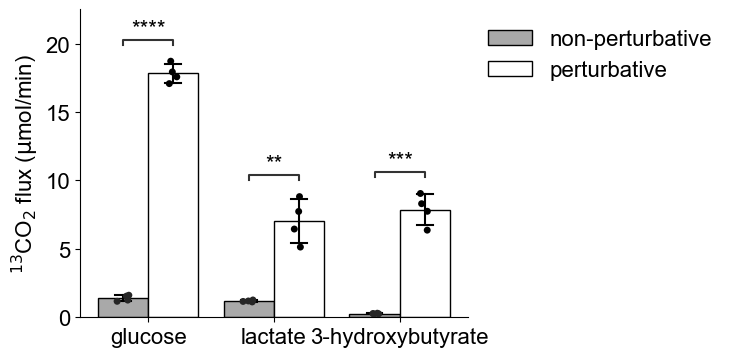

In [16]:
# d) Rate of oxidation CO2_FLUX
f, ax = plt.subplots(1, 1, figsize=(5, 4))

data_filtered = df[(df['TIME'] >= TIME[0]) & (df['TIME'] <= TIME[1])]
# Take mean across time for each tracer
data_filtered = data_filtered.groupby(['TRACER', 'DAY','CAGE'])[['CO2_FLUX','VCO2']].mean().reset_index()

sns.barplot(data=data_filtered, x='TRACER', y='CO2_FLUX', hue='DAY', palette=colors, errorbar='sd',capsize=0.25, 
             edgecolor='black', err_kws={'color': 'black','linewidth': 1.5}, order=order)
sns.stripplot(data=data_filtered, x='TRACER', y='CO2_FLUX', hue='DAY', dodge=True, size=5,
               alpha=1.0, palette='dark:black', legend=False, order=order)

sns.despine()           
plt.ylabel('$^{13}$CO$_2$ flux ($\mathrm{\mu}$mol/min)')   
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

annotator = Annotator(ax, pairs, data=data_filtered,
                        x='TRACER', y='CO2_FLUX',
                        hue='DAY' , order=order, hue_order=hue_order)

annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('./output/C13_CO2.svg', bbox_inches='tight')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lactate_non-perturbative vs. lactate_perturbative: t-test paired samples, P_val:4.553e-01 t=8.551e-01
glucose_non-perturbative vs. glucose_perturbative: t-test paired samples, P_val:9.430e-01 t=7.769e-02
3-hydroxybutyrate_non-perturbative vs. 3-hydroxybutyrate_perturbative: t-test paired samples, P_val:8.971e-01 t=1.406e-01


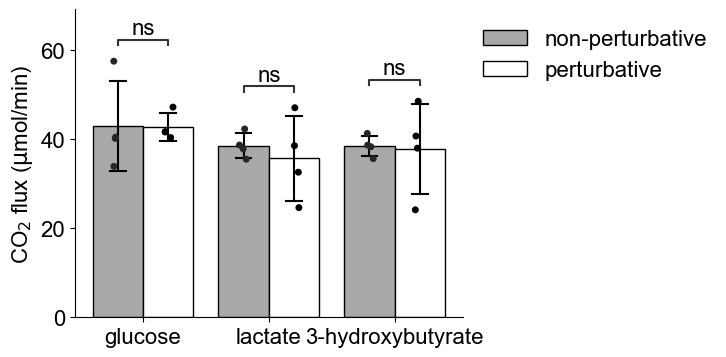

In [17]:
# e) Total CO2 lux (VCO2)

f, ax = plt.subplots(1, 1, figsize=(5, 4))

# Convert VCO2 from ml/min to umol/min
data_filtered = df[(df['TIME'] >= TIME[0]) & (df['TIME'] <= TIME[1])]
# Take mean across time for each tracer
data_filtered = data_filtered.groupby(['TRACER', 'DAY','CAGE'])[['CO2_FLUX','VCO2']].mean().reset_index()

data_filtered['VCO2'] = data_filtered['VCO2'] / (22.4 * 1000) * 1e6 

sns.barplot(data=data_filtered, x='TRACER', y='VCO2', hue='DAY', palette=colors, errorbar='sd',capsize=0.25, 
             edgecolor='black', err_kws={'color': 'black','linewidth': 1.5}, order=order)
sns.stripplot(data=data_filtered, x='TRACER', y='VCO2', hue='DAY', dodge=True, size=5,
               alpha=1.0, palette='dark:black', legend=False, order=order)

sns.despine()           
plt.ylabel(r'CO$_2$ flux ($\mathrm{\mu}$mol/min)')   
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)


annotator = Annotator(ax, pairs, data=data_filtered,
                        x='TRACER', y='VCO2',
                        hue='DAY' , order=order, hue_order=hue_order)

annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.savefig('./output/CO2_flux.svg', bbox_inches='tight')

In [18]:
# Compute the delta between non-perturbative and perturbative for C13-CO2 Flux and Rd 
data_filtered_1 = df[(df['TIME'] >= TIME[0]) & (df['TIME'] <= TIME[1])]
data_filtered_1 = data_filtered_1.groupby(['TRACER', 'DAY','CAGE'])[['CO2_FLUX','VCO2']].mean().reset_index()


# Compute the delta between non-perturbative and perturbative for RD
data_filtered_2 = df2[(df2['TIME'] >= TIME[0]) & (df2['TIME'] <= TIME[1]) & (df2['TRACER'] == df2['COMPOUND_LABEL'])]
data_filtered_2 = data_filtered_2.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()

# Join on cage and day
data_filtered = pd.merge(data_filtered_1, data_filtered_2, on=['DAY','CAGE'])

# Compute Rd
data_filtered['RA'] = data_filtered['TRACER_UMOL_MIN'] * (1 - data_filtered['value'])/ data_filtered['value']
data_filtered['RD'] = data_filtered['TRACER_UMOL_MIN'] + data_filtered['RA']


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_49879/1254228833.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_filtered_2 = data_filtered_2.groupby(['COMPOUND','TRACER', 'DAY','CAGE']).mean().reset_index()


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_49879/3786612114.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data=data_filtered, x='DELTA_RD_norm', y='DELTA_CO2_FLUX', hue='TRACER_x', palette=colors_met, s=100, hue_order=order)


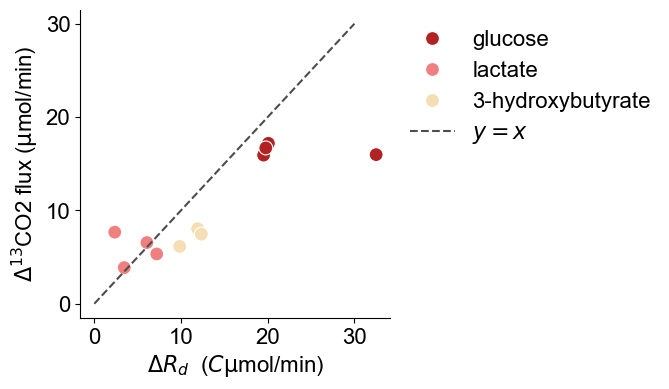

In [19]:
# Compute delta of RD and CO2 flux for each cage between non-perturbative and perturbative
data_filtered['DELTA_RD'] = data_filtered.groupby(['CAGE'])['RD'].diff()
data_filtered['DELTA_RA'] = data_filtered.groupby(['CAGE'])['RA'].diff()

data_filtered['DELTA_RD_norm'] = data_filtered['DELTA_RD']

data_filtered['DELTA_CO2_FLUX'] = data_filtered.groupby(['CAGE'])['CO2_FLUX'].diff()


# Scatter plot of delta RD and delta CO2 flux
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=data_filtered, x='DELTA_RD_norm', y='DELTA_CO2_FLUX', hue='TRACER_x', palette=colors_met, s=100, hue_order=order)
sns.despine()
plt.plot([0, 30], [0, 30], ls="--", c=".3", label='$y=x$')
plt.xlabel('$\Delta R_d$  ($C \mathrm{\mu}$mol/min)')
plt.ylabel('$\Delta ^{13}$CO2 flux ($\mathrm{\mu}$mol/min)')


plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.savefig('./output/delta_RD_vs_delta_CO2_flux.svg',  bbox_inches='tight')

In [20]:
data_filtered

,TRACER_x,DAY,CAGE,CO2_FLUX,VCO2,COMPOUND,TRACER_y,C_LABEL,value,TIME,TRACER_UMOL_MIN,COUNTS,RA,RD,DELTA_RD,DELTA_RA,DELTA_RD_norm,DELTA_CO2_FLUX
0,3-hydroxybutyrate,non-perturbative,3,0.270164,0.858755,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.199621,120.0,0.40160,1449.0,1.610217,2.011817,NaN,NaN,NaN,NaN
1,3-hydroxybutyrate,non-perturbative,6,0.291020,0.925752,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.161503,120.0,0.43200,1449.0,2.242877,2.674877,NaN,NaN,NaN,NaN
2,3-hydroxybutyrate,non-perturbative,11,0.229509,0.798862,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.108681,120.0,0.38720,1449.0,3.175529,3.562729,NaN,NaN,NaN,NaN
3,3-hydroxybutyrate,perturbative,3,8.301751,0.912630,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.864688,120.0,12.04800,599.0,1.885347,13.933347,11.921529,0.275129,11.921529,8.031588
4,3-hydroxybutyrate,perturbative,6,7.746412,0.851529,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.862748,120.0,12.96000,599.0,2.061773,15.021773,12.346896,-0.181104,12.346896,7.455391
5,3-hydroxybutyrate,perturbative,11,6.367576,0.540982,3-hydroxybutyrate,3-hydroxybutyrate_4,4.0,0.865692,120.0,11.61600,599.0,1.802172,13.418172,9.855442,-1.373358,9.855442,6.138066
6,glucose,non-perturbative,1,1.161953,0.906975,glucose,glucose_6,6.0,0.135270,120.0,2.04120,1449.0,13.048581,15.089781,NaN,NaN,NaN,NaN
7,glucose,non-perturbative,4,1.540445,1.289721,glucose,glucose_6,6.0,0.127457,120.0,2.17560,1449.0,14.893671,17.069271,NaN,NaN,NaN,NaN
8,glucose,non-perturbative,9,1.606716,0.759806,glucose,glucose_6,6.0,0.196297,120.0,2.31840,1449.0,9.492295,11.810695,NaN,NaN,NaN,NaN
9,glucose,non-perturbative,12,1.250490,0.900674,glucose,glucose_6,6.0,0.141004,120.0,1.89000,1449.0,11.513845,13.403845,NaN,NaN,NaN,NaN
